<a href="https://colab.research.google.com/github/KelvinM9187/Supervised-Speech-Recognition-with-Transformers/blob/main/IMBD_Movie_Review_with_DistilBERT_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install and import
!pip install -q transformers datasets accelerate evaluate scikit-learn pandas matplotlib seaborn

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
import evaluate
import warnings
warnings.filterwarnings('ignore')

# Check GPU
print(f"GPU available: {torch.cuda.is_available()}")
print(f"GPU name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.0 MB/s eta 0:00:00
GPU available: True
GPU name: Tesla T4


In [2]:
# Configuration
class Config:
    MODEL_NAME = "distilbert-base-uncased"
    MAX_LENGTH = 512
    BATCH_SIZE = 16
    LEARNING_RATE = 2e-5
    EPOCHS = 20
    WEIGHT_DECAY = 0.01
    WARMUP_STEPS = 500
    LOGGING_STEPS = 100
    EVAL_STRATEGY = "epoch"
    SAVE_STRATEGY = "epoch"
    LOAD_BEST_MODEL_AT_END = True
    METRIC_FOR_BEST_MODEL = "eval_f1"
    GREATER_IS_BETTER = True

    # Data
    TRAIN_SAMPLES = 25000
    TEST_SAMPLES = 25000
    VAL_SPLIT = 0.1

    # Output
    OUTPUT_DIR = "./imdb-sentiment-model"
    REPORT_PATH = "./classification_report.txt"

config = Config()

# Preparing IMDB dataset
print("Loading IMDB dataset...")
dataset = load_dataset("imdb")

# Create validation split from training data
train_testvalid = dataset['train'].train_test_split(
    test_size=config.VAL_SPLIT,
    seed=42
)

# Create DatasetDict
dataset = DatasetDict({
    'train': train_testvalid['train'],
    'validation': train_testvalid['test'],
    'test': dataset['test']
})

print(f"Train: {len(dataset['train'])} samples")
print(f"Validation: {len(dataset['validation'])} samples")
print(f"Test: {len(dataset['test'])} samples")

# Display sample
print("\nSample review:")
print(dataset['train'][0]['text'][:200])
print(f"Label: {'Positive' if dataset['train'][0]['label'] == 1 else 'Negative'}")


Loading IMDB dataset...


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Train: 22500 samples
Validation: 2500 samples
Test: 25000 samples

Sample review:
With these people faking so many shots, using old footage, and gassing animals to get them out, not to mention that some of the scenes were filmed on a created set with actors, what's to believe? Old 
Label: Negative


In [3]:
# Tokenization
print(f"\nLoading tokenizer for {config.MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=config.MAX_LENGTH
    )

print("Tokenizing datasets...")
tokenized_datasets = dataset.map(tokenize_function, batched=True)

tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Metrics
def compute_metrics(p):
    preds, labels = p
    preds = np.argmax(preds, axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }



Loading tokenizer for distilbert-base-uncased...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing datasets...


Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]


Loading model distilbert-base-uncased...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model moved to: cuda

STARTING TRAINING


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.231700,0.251959,0.912400,0.912282
2,0.193300,0.237059,0.922800,0.922799
3,0.126600,0.345125,0.924000,0.923974
4,0.059300,0.400599,0.916400,0.916359
5,0.028800,0.469950,0.922000,0.921997


***** train metrics *****
  epoch                    =        5.0
  total_flos               = 13879111GF
  train_loss               =     0.1403
  train_runtime            = 0:25:29.25
  train_samples_per_second =    294.262
  train_steps_per_second   =     18.401

Training completed!


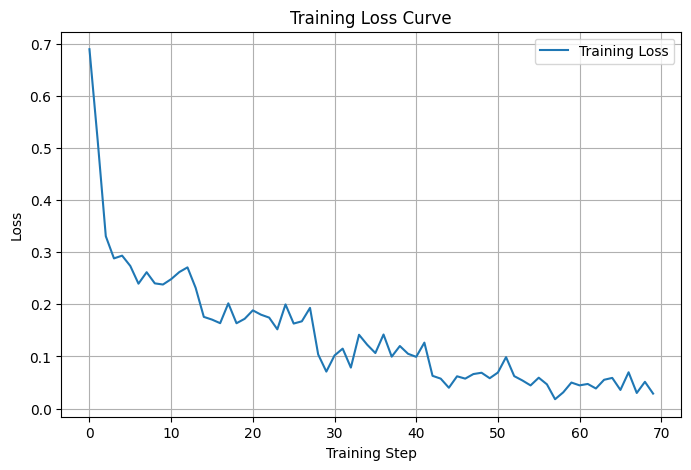

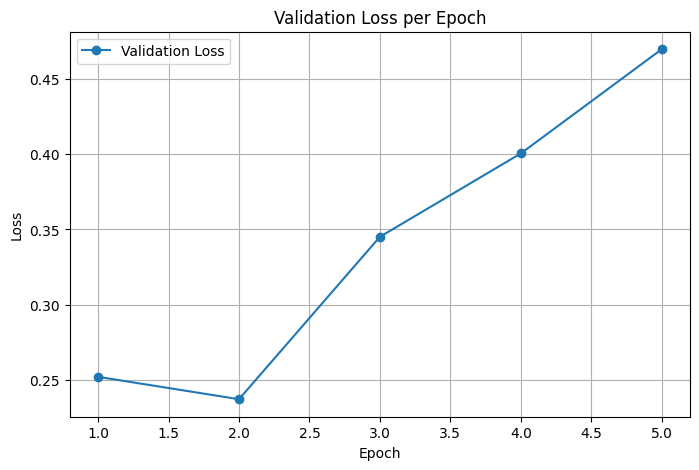

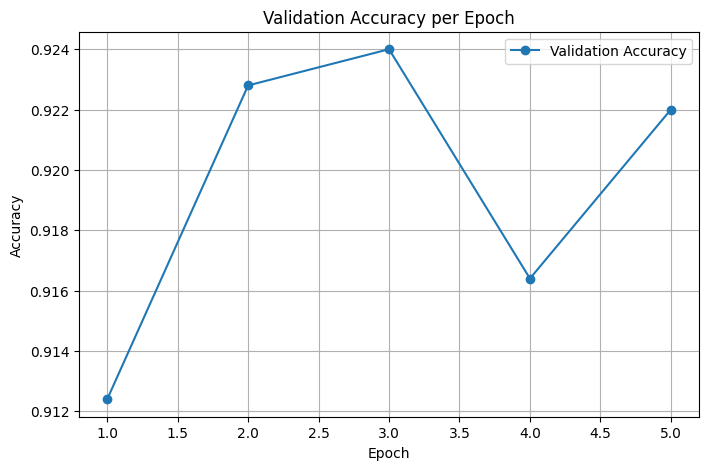

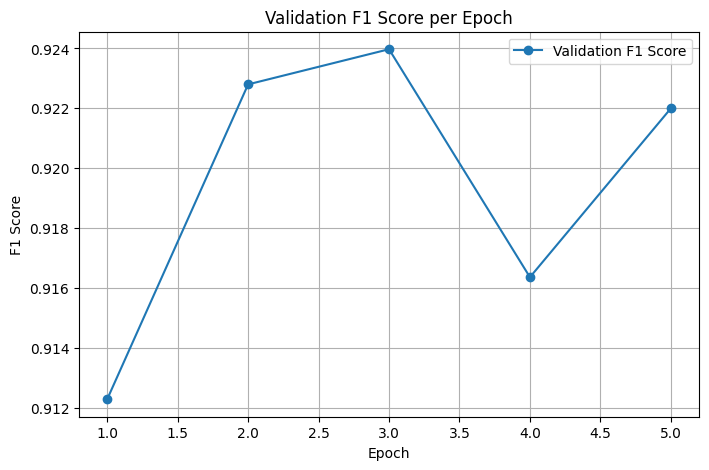

In [4]:
# Loading Model
print(f"\nLoading model {config.MODEL_NAME}...")
model = AutoModelForSequenceClassification.from_pretrained(
    config.MODEL_NAME,
    num_labels=2,
    ignore_mismatched_sizes=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model moved to: {device}")

# Training arguments
training_args = TrainingArguments(
    output_dir=config.OUTPUT_DIR,
    overwrite_output_dir=True,
    num_train_epochs=config.EPOCHS,
    per_device_train_batch_size=config.BATCH_SIZE,
    per_device_eval_batch_size=config.BATCH_SIZE * 2,
    learning_rate=config.LEARNING_RATE,
    weight_decay=config.WEIGHT_DECAY,
    warmup_steps=config.WARMUP_STEPS,
    logging_dir="./logs",
    logging_steps=config.LOGGING_STEPS,
    eval_strategy=config.EVAL_STRATEGY,
    save_strategy=config.SAVE_STRATEGY,
    load_best_model_at_end=config.LOAD_BEST_MODEL_AT_END,
    metric_for_best_model=config.METRIC_FOR_BEST_MODEL,
    greater_is_better=config.GREATER_IS_BETTER,
    report_to="none",
    save_total_limit=2,
    fp16=True,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train the model
print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50)

train_result = trainer.train()

trainer.save_model()
trainer.log_metrics("train", train_result.metrics)
trainer.save_metrics("train", train_result.metrics)
trainer.save_state()

print("\nTraining completed!")

# Training and validation
logs = trainer.state.log_history

train_loss = []
eval_loss = []
eval_accuracy = []
eval_f1 = []
epochs = []

for entry in logs:
    if 'loss' in entry and 'epoch' in entry:
        train_loss.append(entry['loss'])
    if 'eval_loss' in entry:
        eval_loss.append(entry['eval_loss'])
        eval_accuracy.append(entry['eval_accuracy'])
        eval_f1.append(entry['eval_f1'])
        epochs.append(entry['epoch'])

# Plots
plt.figure(figsize=(8,5))
plt.plot(train_loss, label="Training Loss")
plt.title("Training Loss Curve")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, eval_loss, marker='o', label="Validation Loss")
plt.title("Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, eval_accuracy, marker='o', label="Validation Accuracy")
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, eval_f1, marker='o', label="Validation F1 Score")
plt.title("Validation F1 Score per Epoch")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.show()


EVALUATING ON TEST SET



Test Accuracy: 0.9276
Test F1-Score: 0.9276


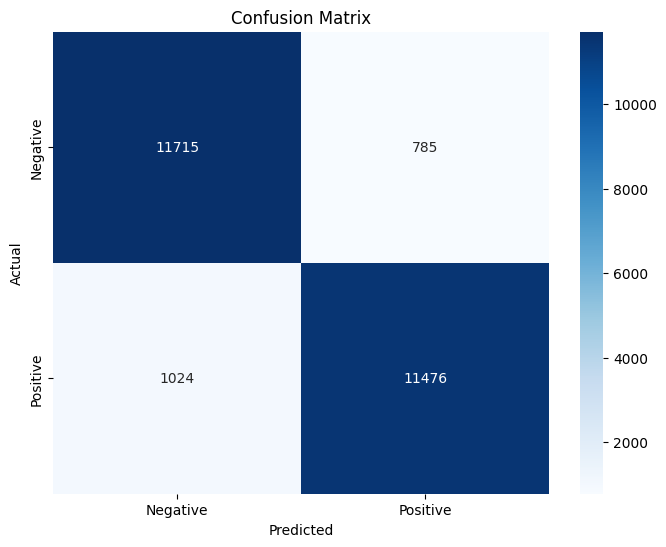


Classification Report:
              precision    recall  f1-score   support

    Negative     0.9196    0.9372    0.9283     12500
    Positive     0.9360    0.9181    0.9269     12500

    accuracy                         0.9276     25000
   macro avg     0.9278    0.9276    0.9276     25000
weighted avg     0.9278    0.9276    0.9276     25000



In [5]:
# Test set evaluation
print("\n" + "="*50)
print("EVALUATING ON TEST SET")
print("="*50)

predictions = trainer.predict(tokenized_datasets["test"])
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average="weighted")

print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Test F1-Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('./confusion_matrix.png', dpi=100, bbox_inches='tight')
plt.show()

# Classification report
report = classification_report(true_labels, pred_labels,
                               target_names=['Negative', 'Positive'],
                               digits=4)
print("\nClassification Report:")
print(report)

with open(config.REPORT_PATH, 'w') as f:
    f.write(f"Model: {config.MODEL_NAME}\n")
    f.write(f"Test Accuracy: {accuracy:.4f}\n")
    f.write(f"Test F1-Score: {f1:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(report)

In [6]:
# Sample predictions
print("\n" + "="*50)
print("SAMPLE PREDICTIONS")
print("="*50)

def predict_sentiment(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=config.MAX_LENGTH)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred_label = torch.argmax(probs, dim=1).item()

    sentiment = "Positive" if pred_label == 1 else "Negative"
    confidence = probs[0][pred_label].item()
    return sentiment, confidence

test_samples = [
    "This movie was absolutely fantastic! The acting was superb.",
    "A complete waste of time. Poor acting and terrible script.",
    "It was okay. Not great, but not terrible either.",
    "One of the worst films I've ever seen.",
    "Brilliant cinematography and outstanding performances!"
]

for i, review in enumerate(test_samples):
    sentiment, confidence = predict_sentiment(review, model, tokenizer)
    print(f"\nReview {i+1}: {review[:80]}...")
    print(f" → Sentiment: {sentiment} (Confidence: {confidence:.2%})")

print("\nSaving final model...")
model.save_pretrained(config.OUTPUT_DIR)
tokenizer.save_pretrained(config.OUTPUT_DIR)

print(f"\nModel saved to: {config.OUTPUT_DIR}")
print("\n" + "="*50)
print("FINISHED!")
print("="*50)

if torch.cuda.is_available():
    print(f"\nGPU Memory allocated: {torch.cuda.memory_allocated(0)/1024**3:.2f} GB")
    print(f"GPU Memory cached: {torch.cuda.memory_reserved(0)/1024**3:.2f} GB")



SAMPLE PREDICTIONS

Review 1: This movie was absolutely fantastic! The acting was superb....
 → Sentiment: Positive (Confidence: 99.59%)

Review 2: A complete waste of time. Poor acting and terrible script....
 → Sentiment: Negative (Confidence: 99.89%)

Review 3: It was okay. Not great, but not terrible either....
 → Sentiment: Negative (Confidence: 98.05%)

Review 4: One of the worst films I've ever seen....
 → Sentiment: Negative (Confidence: 99.88%)

Review 5: Brilliant cinematography and outstanding performances!...
 → Sentiment: Positive (Confidence: 99.73%)

Saving final model...

Model saved to: ./imdb-sentiment-model

FINISHED!

GPU Memory allocated: 0.77 GB
GPU Memory cached: 2.79 GB
